# **Chapter 2: Feature engineering in computational chemistry**
## *Data representation matters.*

In this notebook, we will demonstrate the importance of data representation to model accuracy. 

We will use a small, balanced dataset of 8-residue amino acid sequences from the [MEROPS Peptidase Database](https://www.ebi.ac.uk/merops/) (*n* = 4000). These amino acid sequences are peptidase cleavage sites and non-cleavage sites. Each site has 4 residues flanking either side. The **labels** indicate whether an observation is a cleavage site (1) or not (0). The **features** are encoded by 5 disparate methods:

1. One-hot encoding, where each residue is represented by a zero-vector with a single 1 at a unique index assigned to the given amino acid.
2. Ordinal encoding, where each residue is represented by an integer assigned to the given amino acid.
3. ProtFP ([Van Westen et al 2013](https://doi.org/10.1186/1758-2946-5-41)), which constructs artificial features from physicochemical descriptors using principal component analysis.
4. Z-Scale ([Hellberg et al 1987](https://doi.org/10.1021/jm00390a003) / [Sandberg et al 1998](https://doi.org/10.1021/jm9700575)) which constructs artificial features from physicochemical descriptors using principal component analysis.
5. UniRep ([Alley et al 2019](https://doi.org/10.1038/s41592-019-0598-1)), a learned representation produced by a recurrent neural network.

As the results demonstrate, the optimal input representation can vary by algorithm and is not always the intuitive choice. Further, dimensionality does not necessarily correlate with accuracy.

*Analysis by Jacqueline R. M. A. Maasch | August 2021*

## Table of contents

* [Preamble](#Preamble)
* [Define functions](#Define-functions)
* [Read data](#Read-data)
* [Train and test](#Train-and-test)
    - [Random forest](#Random-forest)
    - [Support vector machine](#Support-vector-machine)
    - [K nearest neighbor](#K-nearest-neighbor)
* [Interpretation](#Interpretation)

## Preamble

In [1]:
# Importations.
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from ast import literal_eval
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

# Set random state for reproducibility.
seed = 500

## Define functions

Here we will define several convenience functions that will keep our code DRY.

In [2]:
def train_test(model, X, y, seed = 500, test_frac = 0.2):
    
    '''
    This function wraps sklearn's train-test split, model fitting,
    and prediction functionality.
    
    Parameters:
        model: a sklearn model (e.g. KNeighborsClassifier()).
        X: a dataframe column containing feature vectors.
        y: a dataframe column containing labels.
        seed (default = 500): random state seed as integer.
        test_frac (default = 0.2): float indicated fraction to
            set aside for the test set.
    
    Return:
        acc: model accuracy as float.
    '''
    
    # Perform train-test split (80% / 20%).
    X = np.array(X.values.tolist())
    y = np.array(y.values.tolist())
    
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size = test_frac,
                                                        random_state = seed,
                                                        stratify = y)

    # Fit model to training set.
    start_time = time.time()
    model.fit(X_train, y_train)
    print("\nFit complete in {:0.2f} seconds.".format(time.time() - start_time))

    # Predict labels.
    start_time = time.time()
    y_pred = model.predict(X_test)
    acc = metrics.accuracy_score(y_test, y_pred)
    print("Prediction complete in {:0.2f} seconds.".format(time.time() - start_time))
    print("\nAccuracy on test set = {:0.2f}%".format(acc * 100))
    
    # Return model accuracy.
    return acc
    
    
def iter_reps(df, model, start_index = 2, label_index = 1):
    
    '''
    This function iterates through data representations to fit sklearn
    models and assess their accuracies.
    
    Parameters:
        df: a pandas dataframe containing label and feature columns.
        model: a sklearn model (e.g. KNeighborsClassifier()). 
        start_index (default = 2): column index of first data representation.
        label_index (default = 1): column index of label column.
    
    Return:
        acc_list: list of accuracies as floats.
    '''
    
    # Init empty list to store accuracies.
    acc_list = []
    
    # Iterate through representation columns to train and test models.
    for i in range(start_index, len(df.columns)):
    
        print("\n~~~~~~~~~~ {} ~~~~~~~~~~".format(df.columns[i]))

        X = df.iloc[:,i].apply(literal_eval)
        y = df.iloc[:,label_index]
        
        print("\nDimensions =", len(X[0]))

        acc = train_test(model, X, y)
        acc_list.append(acc)
        
    # Return accuracy list.
    return acc_list


def plot_acc_by_dims(accuracies, dimensions = [8, 160, 64, 24, 64]):
    
    '''
    This function plots the accuracy of each model by the dimensionality of
    the data representation that it was trained on.
    
    Parameters:
        accuracies: list-like structure containing accuracy per data
            representation, as floats.
        dimensions (default = [8, 160, 64, 24, 64]): list-like structure 
            containing dimensionality per representation, as integers.
    
    Return:
        None.
    '''
    
    plt.scatter(dimensions, accuracies)
    plt.xlabel("\nDimensions")
    plt.ylabel("Accuracy\n")
    plt.show()

## Read data

In [3]:
# Read data file.
df = pd.read_csv("input_rep_demo.csv")

In [4]:
# Explore data.
display(df.head(2))
print(df.info())

# Demonstrate that dataset is balanced.
print("\nObservations per label:\n{}".format(df.Label.value_counts()))

,Sequence,Label,Ordinal,One-hot,ProtFP,Z-Scale,UniRep
0,IPFCGEID,1,"[7, 12, 4, 1, 5, 3, 7, 2]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[6.58, -1.73, -2.49, 1.09, -0.34, -0.28, 1.97,...","[-4.44, -1.68, -1.03, -1.22, 0.88, 2.23, -4.92...","[-0.09122531861066818, 0.08572831749916077, 0...."
1,LRDYFEEY,1,"[9, 14, 2, 19, 4, 3, 3, 19]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[5.76, -1.33, -1.71, 0.63, -1.7, 0.71, -0.05, ...","[-4.19, -1.03, -0.98, 2.88, 2.52, -3.44, 3.64,...","[-0.1062292754650116, 0.09696033596992493, -0...."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sequence  4000 non-null   object
 1   Label     4000 non-null   int64 
 2   Ordinal   4000 non-null   object
 3   One-hot   4000 non-null   object
 4   ProtFP    4000 non-null   object
 5   Z-Scale   4000 non-null   object
 6   UniRep    4000 non-null   object
dtypes: int64(1), object(6)
memory usage: 218.9+ KB
None

Observations per label:
0    2000
1    2000
Name: Label, dtype: int64


## Train and test

### Random forest

In [5]:
# Iterate through data representations to train and test models.
rf = RandomForestClassifier(random_state = seed)
rf_accuracies = iter_reps(df, rf)


~~~~~~~~~~ Ordinal ~~~~~~~~~~

Dimensions = 8

Fit complete in 0.27 seconds.
Prediction complete in 0.01 seconds.

Accuracy on test set = 67.25%

~~~~~~~~~~ One-hot ~~~~~~~~~~

Dimensions = 160

Fit complete in 0.34 seconds.
Prediction complete in 0.02 seconds.

Accuracy on test set = 73.25%

~~~~~~~~~~ ProtFP ~~~~~~~~~~

Dimensions = 64

Fit complete in 0.59 seconds.
Prediction complete in 0.01 seconds.

Accuracy on test set = 71.12%

~~~~~~~~~~ Z-Scale ~~~~~~~~~~

Dimensions = 24

Fit complete in 0.36 seconds.
Prediction complete in 0.01 seconds.

Accuracy on test set = 70.50%

~~~~~~~~~~ UniRep ~~~~~~~~~~

Dimensions = 64

Fit complete in 1.34 seconds.
Prediction complete in 0.01 seconds.

Accuracy on test set = 62.88%


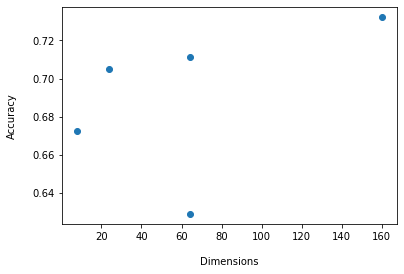

In [6]:
# Plot model accuracy by total dimensions per input representation.
plot_acc_by_dims(rf_accuracies)

## Support vector machine

In [7]:
# Iterate through data representations to train and test models.
svm = SVC(random_state = seed)
svm_accuracies = iter_reps(df, svm)


~~~~~~~~~~ Ordinal ~~~~~~~~~~

Dimensions = 8

Fit complete in 0.24 seconds.
Prediction complete in 0.08 seconds.

Accuracy on test set = 58.88%

~~~~~~~~~~ One-hot ~~~~~~~~~~

Dimensions = 160

Fit complete in 0.47 seconds.
Prediction complete in 0.18 seconds.

Accuracy on test set = 73.12%

~~~~~~~~~~ ProtFP ~~~~~~~~~~

Dimensions = 64

Fit complete in 0.32 seconds.
Prediction complete in 0.09 seconds.

Accuracy on test set = 68.00%

~~~~~~~~~~ Z-Scale ~~~~~~~~~~

Dimensions = 24

Fit complete in 0.29 seconds.
Prediction complete in 0.08 seconds.

Accuracy on test set = 66.75%

~~~~~~~~~~ UniRep ~~~~~~~~~~

Dimensions = 64

Fit complete in 0.35 seconds.
Prediction complete in 0.11 seconds.

Accuracy on test set = 62.00%


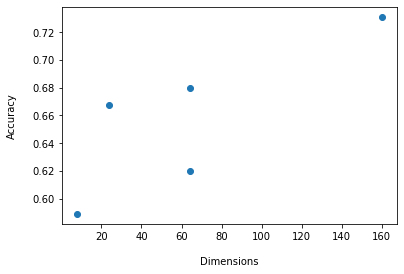

In [8]:
# Plot model accuracy by total dimensions per input representation.
plot_acc_by_dims(svm_accuracies)

## K-nearest neighbors

In [9]:
# Iterate through data representations to train and test models.
knn = KNeighborsClassifier()
knn_accuracies = iter_reps(df, knn)


~~~~~~~~~~ Ordinal ~~~~~~~~~~

Dimensions = 8

Fit complete in 0.00 seconds.
Prediction complete in 0.02 seconds.

Accuracy on test set = 53.12%

~~~~~~~~~~ One-hot ~~~~~~~~~~

Dimensions = 160

Fit complete in 0.00 seconds.
Prediction complete in 0.09 seconds.

Accuracy on test set = 63.50%

~~~~~~~~~~ ProtFP ~~~~~~~~~~

Dimensions = 64

Fit complete in 0.00 seconds.
Prediction complete in 0.06 seconds.

Accuracy on test set = 60.25%

~~~~~~~~~~ Z-Scale ~~~~~~~~~~

Dimensions = 24

Fit complete in 0.00 seconds.
Prediction complete in 0.07 seconds.

Accuracy on test set = 57.50%

~~~~~~~~~~ UniRep ~~~~~~~~~~

Dimensions = 64

Fit complete in 0.00 seconds.
Prediction complete in 0.07 seconds.

Accuracy on test set = 58.25%


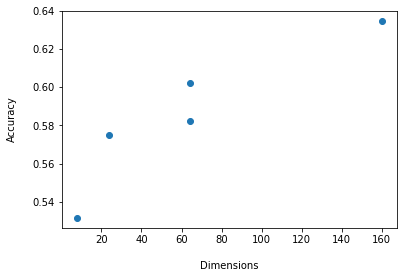

In [10]:
# Plot model accuracy by total dimensions per input representation.
plot_acc_by_dims(knn_accuracies)

## Interpretation

Counter-intuitively, the one-hot encoding conferred superior accuracy for all three algorithms tested. This is might come as a surprise, given that it contains no biological information within itself and most dimensions are zero-valued. 